In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from keras.layers import Dropout, RepeatVector, TimeDistributed,Bidirectional, Reshape,Flatten
from sklearn.preprocessing import StandardScaler
np.random.seed(1)

In [148]:
#Load the sequence data from csv
#I:\DM PROJECT\originaldataset\AEP_hourly.csv
df = pd.read_csv('I:\DM PROJECT\originaldataset\AEP_hourly.csv')
requests = pd.DataFrame(data=df,columns=['AEP_MW'])
#if any missing value fill it by previous value and convert all requests into integer type
requests.ffill(inplace=True)
requests["AEP_MW"]=requests["AEP_MW"].astype(float).astype(int)
#Review loaded data
print(requests.dtypes)
requests.head()

AEP_MW    int32
dtype: object


,AEP_MW
0,13478
1,12865
2,12577
3,12517
4,12670


In [149]:
dataset = df
dataset["Month"] = pd.to_datetime(df["Datetime"]).dt.month
dataset["Year"] = pd.to_datetime(df["Datetime"]).dt.year
dataset["Date"] = pd.to_datetime(df["Datetime"]).dt.date
dataset["Time"] = pd.to_datetime(df["Datetime"]).dt.time
dataset["Week"] = pd.to_datetime(df["Datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(df["Datetime"]).dt.day_name()
dataset = df.set_index("Datetime")
dataset.index = pd.to_datetime(dataset.index)

In [150]:
# How many Unique Year do we Have in Dataset 
print(df.Year.unique(),"\n")
print("Total Number of Unique Year", df.Year.nunique(), "\n")

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018] 

Total Number of Unique Year 15 



C:\Users\Administrator\AppData\Local\Temp\ipykernel_6880\3795206309.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["AEP_MW"], kde=True)


Text(0.5, 1.0, 'Ennergy Distribution')

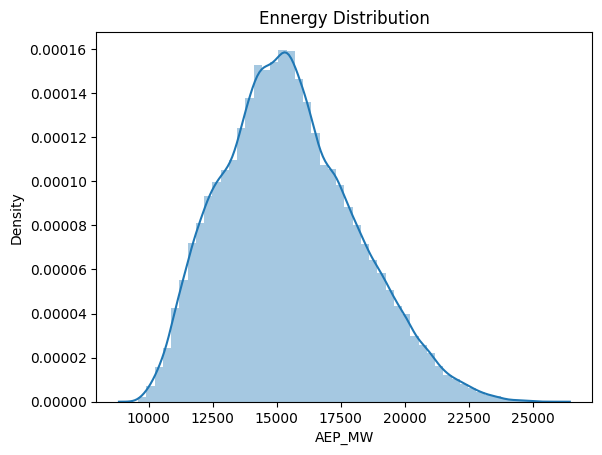

In [151]:
#plot and data visualization
# Using displot
sns.distplot(df["AEP_MW"], kde=True)
plt.title("Ennergy Distribution")

<Axes: xlabel='Year', ylabel='AEP_MW'>

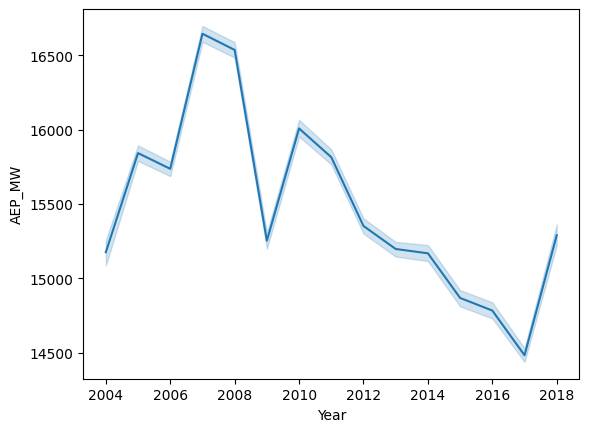

In [152]:
#shows the Relationship of Energy vs Year
sns.lineplot(x=df["Year"],y=df["AEP_MW"], data=df)

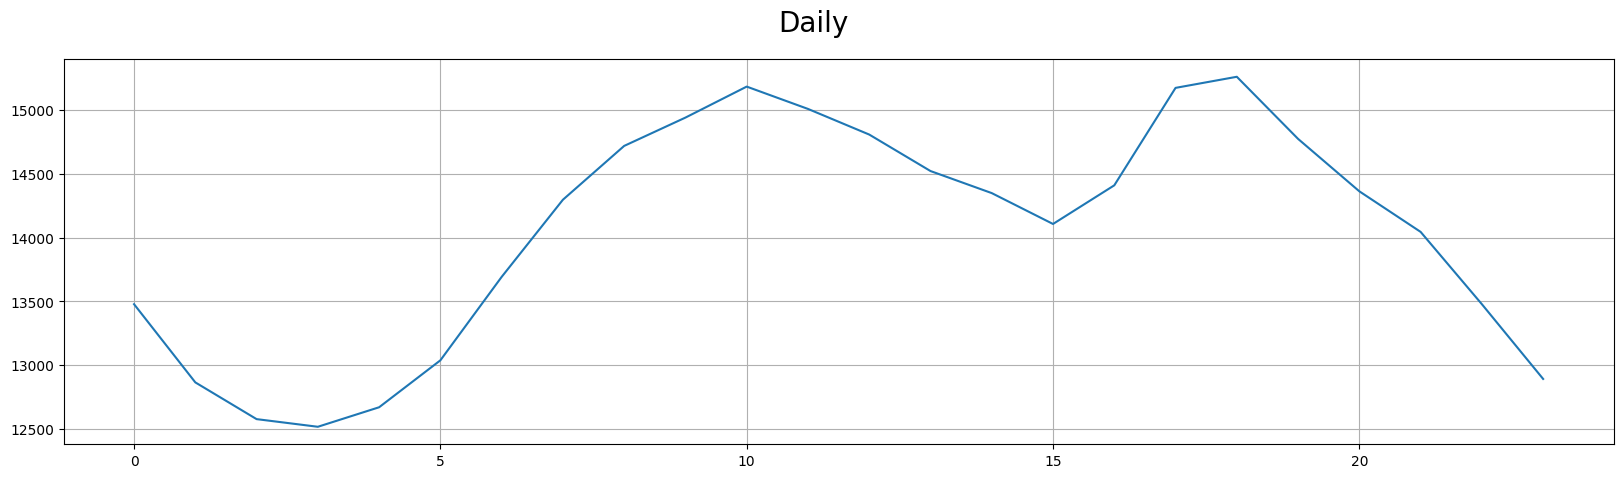

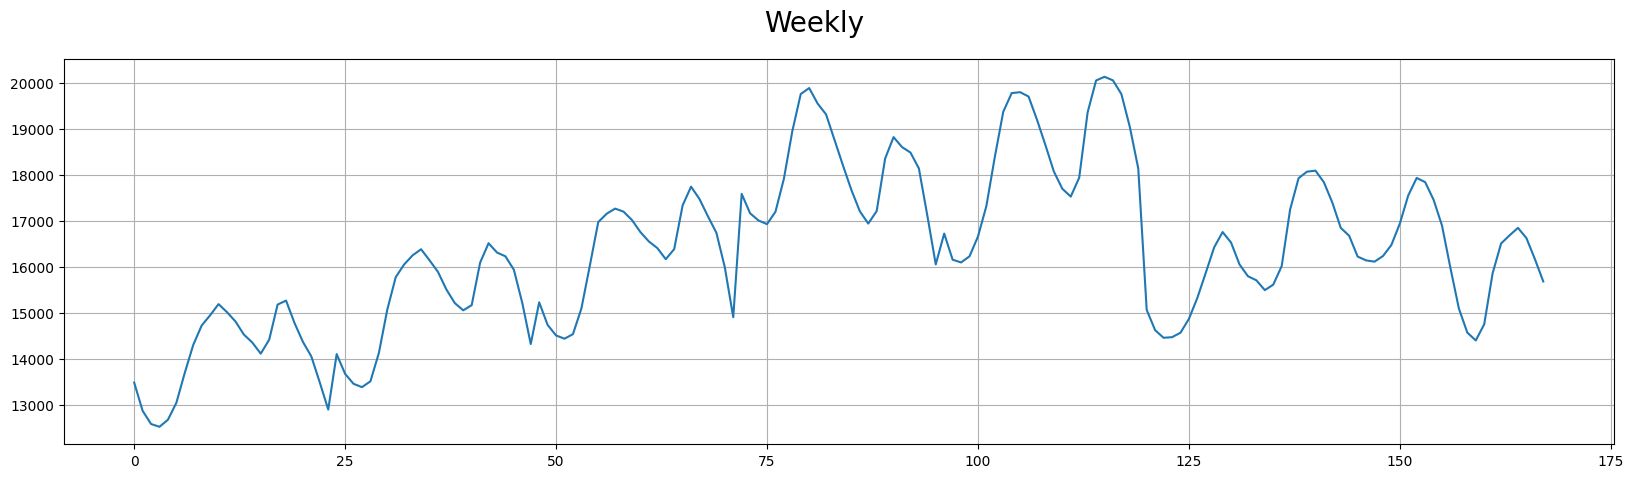

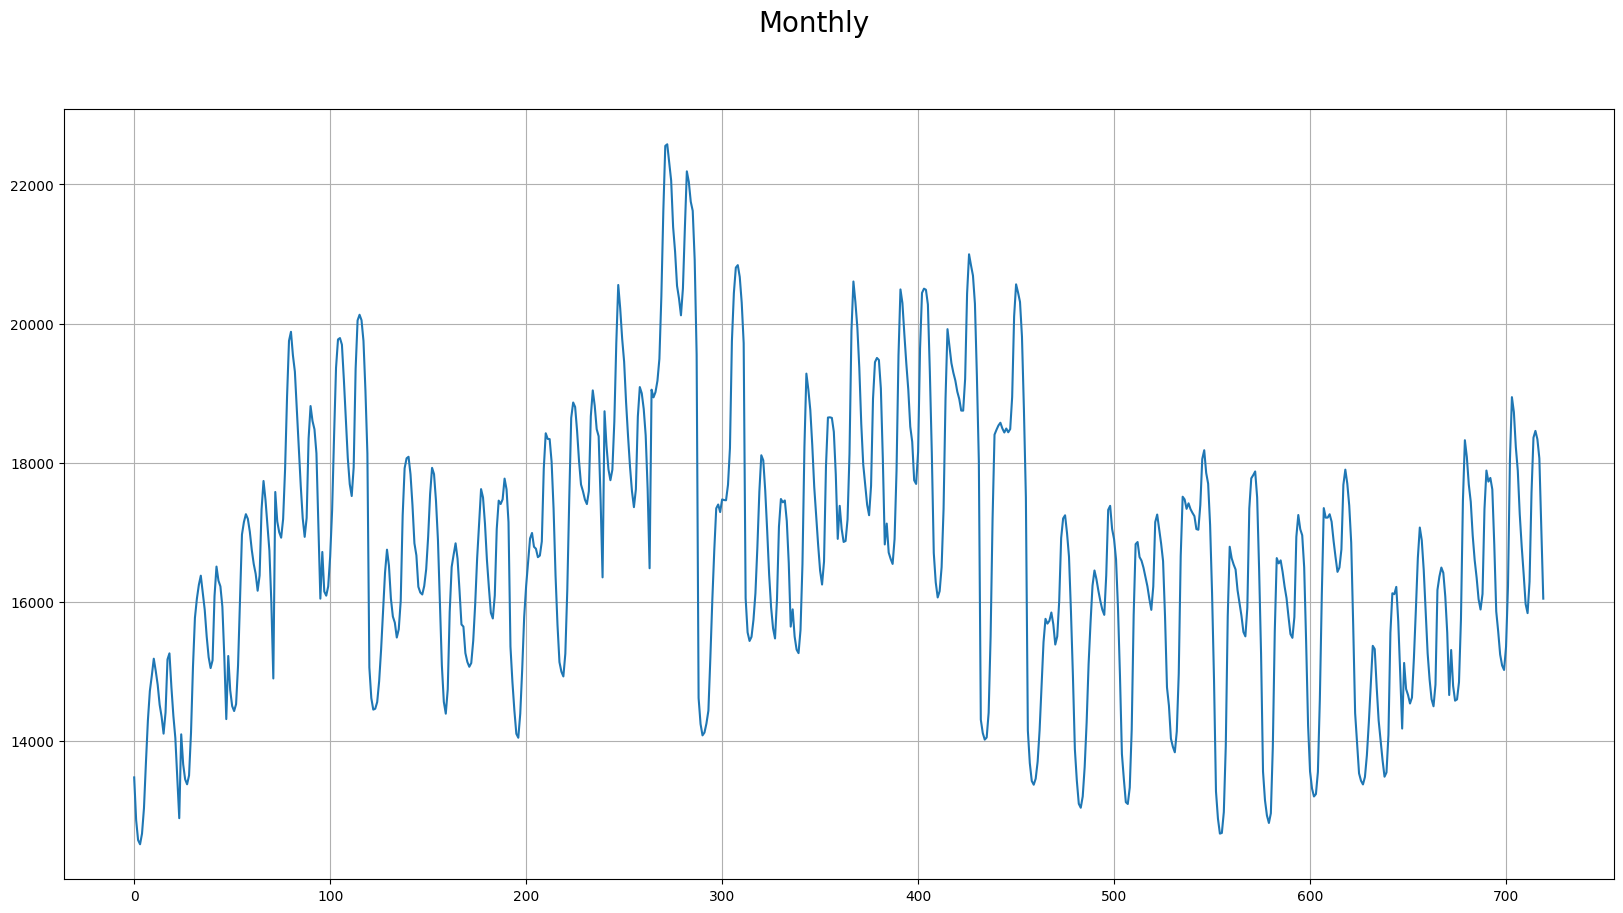

In [153]:
#plot the data loaded to visualize trends
#daily

plt.figure(figsize=(20,5)).suptitle("Daily",fontsize=20)
plt.plot(requests["AEP_MW"].head(24))
plt.grid()
# plt.show()

#weekly
plt.figure(figsize=(20,5)).suptitle("Weekly",fontsize=20)
plt.plot(requests["AEP_MW"].head(168))
plt.grid()
# plt.show()

#monthly
plt.figure(figsize=(20,10)).suptitle("Monthly",fontsize=20)
plt.plot(requests["AEP_MW"].head(720))
plt.grid()
# plt.show()


In [154]:
df.head()
df.isnull().sum()

Datetime    0
AEP_MW      0
Month       0
Year        0
Date        0
Time        0
Week        0
Day         0
dtype: int64

In [155]:
df2 = df.dropna()
df2.head()

,Datetime,AEP_MW,Month,Year,Date,Time,Week,Day
0,2004-12-31 01:00:00,13478.0,12,2004,2004-12-31,01:00:00,53,Friday
1,2004-12-31 02:00:00,12865.0,12,2004,2004-12-31,02:00:00,53,Friday
2,2004-12-31 03:00:00,12577.0,12,2004,2004-12-31,03:00:00,53,Friday
3,2004-12-31 04:00:00,12517.0,12,2004,2004-12-31,04:00:00,53,Friday
4,2004-12-31 05:00:00,12670.0,12,2004,2004-12-31,05:00:00,53,Friday


In [156]:
#scale the data
print("Request Range before scaling:",min(requests.AEP_MW),max(requests.AEP_MW))
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Request Range after scaling:",min(scaled_requests),max(scaled_requests))

#Traing data has to be sequential
train_size = int(len(df)*0.99)
test_size =len(df)-train_size

#Number of samples to lookback for each sample
#720 default
lookback =720

#sperate training and test data
train_data = scaled_requests[0:train_size,:]

#Add an additional week for lookback
test_data = scaled_requests[train_size:len(df),:1]

print("\n Shaped of Train ,Test :", train_data.shape ,test_data.shape)

Request Range before scaling: 9581 25695
Request Range after scaling: [-2.28391613] [3.93437215]

 Shaped of Train ,Test : (120060, 1) (1213, 1)


Train / Test Split

In [157]:
# fig, ax = plt.subplots(figsize=(15, 5))
# train_data.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
# test_data.plot(ax=ax, label='Test Set')
# ax.axvline('01-01-2015', color='black', ls='--')
# ax.legend(['Training Set', 'Test Set'])
# plt.show()

In [158]:
##########################################################################################################
#Build a LSTM model with Keras
##########################################################################################################
#pepare RNN Dataset
def create_rnn_dataset(data, lookback=1):
  
  data_x,data_y = [],[]
  for i in range(len(data)- lookback -1):
    a = data[i:(i + lookback),0]
    data_x.append(a)
    data_y.append(data[i + lookback,0])
  return np.array(data_x),np.array(data_y)

#create x and y for training
x_train , y_train = create_rnn_dataset(train_data , lookback)

#Reshape for use with LSTM
x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))

print("shapes of x,y:",x_train.shape , y_train.shape)
########################################################################################################

shapes of x,y: (119339, 1, 720) (119339,)


In [159]:
tf.random.set_seed(21)
ts_model =  Sequential()
#Add LSTM
#128 units - positive integers dimensionality of the outputspace
# The 1 in the input shape represents the number of features (in this case, only one feature is used for each timestep).
#input_shape=(1,lookback) means that the input data to the LSTM layer should have a shape of (batch_size, 1, lookback), where batch_size represents the number of samples in each batch of input data.
ts_model.add(LSTM(64,return_sequences=True,activation = 'tanh',input_shape=(x_train.shape[1],x_train.shape[2])))
ts_model.add(Dropout(rate=0.2))
ts_model.add(LSTM(64,activation = 'tanh',return_sequences=True))
#ts_model.add(Dropout(rate=0.2))
#ts_model.add(LSTM(64,return_sequences=True))
#ts_model.add(Dropout(rate=0.2))
ts_model.add(LSTM(64,activation = 'tanh'))
#ts_model.add(Dropout(rate=0.2))
# Add RepeatVector layer
#ts_model.add(RepeatVector(x_train.shape[1]))
# Add TimeDistributed layer
#ts_model.add(TimeDistributed(Dense(1)))
ts_model.add(Dense(1))
ts_model.compile(loss="mean_squared_error",optimizer="adam")
ts_model.summary()
history = ts_model.fit(x_train, y_train, epochs=200,validation_split=0.1, batch_size=1500,verbose=1)


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 1, 64)             200960    
                                                                 
 dropout_31 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_67 (LSTM)              (None, 1, 64)             33024     
                                                                 
 lstm_68 (LSTM)              (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 267,073
Trainable params: 267,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
72/72 [============================

In [160]:
from keras.utils import plot_model

# plot the model architecture
plot_model(ts_model, show_shapes=True, to_file='lstm.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


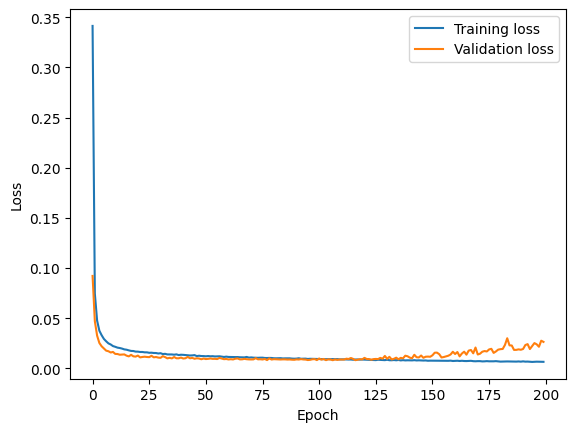

In [161]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [162]:

############################################################################################################
#Test the Model
#############################################################################################################
#Preprocess
test_req_x , test_req_y =create_rnn_dataset(test_data , lookback)
test_req_x = np.reshape(test_req_x,(test_req_x.shape[0],1,test_req_x.shape[1]))
ts_model.evaluate(test_req_x , test_req_y, verbose=1)

#predict for the training dataset
predict_on_train = ts_model.predict(x_train)
#Prdeict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

#train_mae_loss = np.mean(np.abs(predict_on_train - x_train), axis=1)

16/16 [==============================] - 0s 3ms/step


In [163]:
##############################################################################################################
#accuracy score
############################################################################################################
from sklearn import metrics
import os
score = np.sqrt(metrics.mean_squared_error(predict_on_test,test_req_y))
print(f'After training the score is:{score}')
#########################################################################################################
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)


After training the score is:0.2448399625726577


In [164]:
###############################################################################################################
os.chdir(r'I:\DM PROJECT\modelsave')
os.getcwd()
ts_model.save(os.path.join(os.getcwd(),"lstm_anomaly_model.h5"))